### **Install and import library**

In [ ]:
pip install transformers

     |████████████████████████████████| 3.1 MB 12.2 MB/s 
     |████████████████████████████████| 59 kB 6.9 MB/s 
     |████████████████████████████████| 895 kB 43.0 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 3.3 MB 30.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
pip install vncorenlp

     |████████████████████████████████| 2.6 MB 12.7 MB/s 
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=a294bf41437612d932c620594b2d7e5a1f6c7c91f644a3beff5955f2ea136f96
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp


In [ ]:
!mkdir -p vncorenlp/models/wordsegmenter
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
!wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
!mv VnCoreNLP-1.1.1.jar vncorenlp/
!mv vi-vocab vncorenlp/models/wordsegmenter/
!mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

--2021-11-05 10:40:53--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27412575 (26M) [application/octet-stream]
Saving to: ‘VnCoreNLP-1.1.1.jar’

VnCoreNLP-1.1.1.jar 100%[===================>]  26.14M   168MB/s    in 0.2s    

2021-11-05 10:40:54 (168 MB/s) - ‘VnCoreNLP-1.1.1.jar’ saved [27412575/27412575]

--2021-11-05 10:40:54--  https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting respon

In [ ]:
from google.colab import drive
import os
import re
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from vncorenlp import VnCoreNLP
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, BertTokenizer, BertForSequenceClassification

### **Connect to Google Drive**

In [ ]:
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
DIR_ROOT = '/gdrive/MyDrive/FakeCommentDetection'
DIR_DATASET = os.path.join(DIR_ROOT, 'dataset')

PATH_TRAIN = os.path.join(DIR_DATASET, 'train.csv')
PATH_DEV = os.path.join(DIR_DATASET, 'dev.csv')
PATH_TEST = os.path.join(DIR_DATASET, 'test.csv')

STOPWORDS_PATH = os.path.join(DIR_ROOT, 'vietnamese-stopwords-dash.txt')

MODEL_DIR = os.path.join(DIR_ROOT, 'transformer_model')
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

In [ ]:
labels_task_1 = ["no-spam", "spam"]

def show_predict_result(trainer, test_dataset, y_test, labels):
    y_pred_classify = trainer.predict(test_dataset)
    y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
    cf = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(cf, index = labels, columns = labels)
    sns.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 30})
    print("F1 - micro:", f1_score(y_test, y_pred, average='micro'))
    print("F1 - macro:", f1_score(y_test, y_pred, average='macro'))
    print("Accuracy:", accuracy_score(y_test, y_pred))


class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

### **Load data**

In [ ]:
train_data = pd.read_csv(PATH_TRAIN)
X_train = train_data.iloc[:, 0:2]
y_train = train_data.iloc[:, 2:4]

dev_data = pd.read_csv(PATH_DEV)
X_dev = dev_data.iloc[:, 0:2]
y_dev = dev_data.iloc[:, 2:4]

test_data = pd.read_csv(PATH_TEST)
X_test = test_data.iloc[:, 0:2]
y_test = test_data.iloc[:, 2:4]

In [ ]:
vncorenlp = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m')

In [ ]:
with open(STOPWORDS_PATH, "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

In [ ]:
def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)

    return train_sentences


def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)


def preprocess(text, tokenized=True, lowercased=True):
    # text = ViTokenizer.tokenize(text)
    # text = ' '.join(vncorenlp.tokenize(text)[0])
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    if tokenized:
        pre_text = ""
        sentences = vncorenlp.tokenize(text)
        for sentence in sentences:
            pre_text += " ".join(sentence)
        text = pre_text
    return text


def pre_process_features(X, y1, y2, tokenized=True, lowercased=True):
    X = np.array(X)
    y1 = np.array(y1)
    y2 = np.array(y2)
    X = [preprocess(str(p), tokenized=tokenized, lowercased=lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y1, idx)
            np.delete(y2, idx)
    return X, y1, y2

In [ ]:
train_X, train_y, train_y_spam = pre_process_features(X_train['Comment'], y_train['Label'], y_train['SpamLabel'], tokenized=True, lowercased = False)
dev_X, dev_y, dev_y_spam = pre_process_features(X_dev['Comment'], y_dev['Label'], y_dev['SpamLabel'], tokenized=True, lowercased = False)
test_X, test_y, test_y_spam = pre_process_features(X_test['Comment'], y_test['Label'], y_test['SpamLabel'], tokenized=True, lowercased = False)

### **PhoBERT**

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base", num_labels = 2)
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y)
dev_dataset = BuildDataset(dev_encodings, dev_y)
test_dataset = BuildDataset(test_encodings, test_y)

OUTPUT_DIR = os.path.join(MODEL_DIR, 'phobert', 'task_1')

training_args = TrainingArguments(
    output_dir= OUTPUT_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

trainer.train()
trainer.save_model(OUTPUT_DIR)

***** Running training *****
  Num examples = 14306
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1790


Step,Training Loss
500,0.415100
1000,0.297500
1500,0.239400


Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_1/checkpoint-500
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_1/checkpoint-500/config.json
Model weights saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_1/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_1/checkpoint-1000
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_1/checkpoint-1000/config.json
Model weights saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_1/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_1/checkpoint-1500
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/phobert/task_1/checkpoint-1500/config.json
Model weights saved in /gdrive/MyDrive/FakeComm

***** Running Prediction *****
  Num examples = 3974
  Batch size = 16


F1 - micro: 0.9001006542526422
F1 - macro: 0.868886902676857
Accuracy: 0.9001006542526422


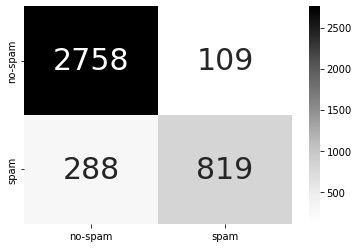

In [ ]:
show_predict_result(trainer, test_dataset, test_y, labels_task_1)

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("NlpHUST/vibert4news-base-cased", num_labels = 4)
tokenizer = BertTokenizer.from_pretrained("NlpHUST/vibert4news-base-cased", use_fast=False)

loading configuration file https://huggingface.co/NlpHUST/vibert4news-base-cased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/46dd323249fff6d5e77138474e0b533c3f6c9dd56fea430098410d1418fb8ff5.b9a023ccbf3e5dd443c3f6ec225709ded1fd2ea513add7fbbd20104481407038
Model config IBertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "directionality": "bidi",
  "eos_token_id": 2,
  "force_dequant": "none",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "ibert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "pooler_fc

In [ ]:
train_encodings = tokenizer(train_X, truncation=True, padding=True, max_length=100)
dev_encodings = tokenizer(dev_X, truncation=True, padding=True, max_length=100)
test_encodings = tokenizer(test_X, truncation=True, padding=True, max_length=100)

train_dataset = BuildDataset(train_encodings, train_y_spam)
dev_dataset = BuildDataset(dev_encodings, dev_y_spam)
test_dataset = BuildDataset(test_encodings, test_y_spam)

OUTPUT_DIR = os.path.join(MODEL_DIR, 'bert4news', 'task_2')

training_args = TrainingArguments(
    output_dir= OUTPUT_DIR,
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    no_cuda=False,
    do_eval=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset
)

trainer.train()
trainer.save_model(OUTPUT_DIR)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
***** Running training *****
  Num examples = 14306
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1790


Step,Training Loss
500,0.696400
1000,0.549300
1500,0.442800


Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/bert4news/task_2/checkpoint-500
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/bert4news/task_2/checkpoint-500/config.json
Model weights saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/bert4news/task_2/checkpoint-500/pytorch_model.bin
Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/bert4news/task_2/checkpoint-1000
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/bert4news/task_2/checkpoint-1000/config.json
Model weights saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/bert4news/task_2/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /gdrive/MyDrive/FakeCommentDetection/transformer_model/bert4news/task_2/checkpoint-1500
Configuration saved in /gdrive/MyDrive/FakeCommentDetection/transformer_model/bert4news/task_2/checkpoint-1500/config.json
Model weights saved in /gdrive/

***** Running Prediction *****
  Num examples = 3974
  Batch size = 16


F1 - micro: 0.8616004026170104
F1 - macro: 0.6262327249987143
Accuracy: 0.8616004026170105


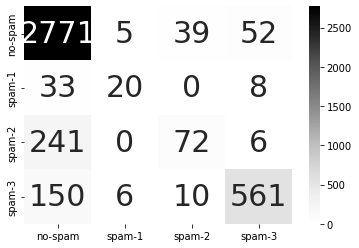

In [ ]:
show_predict_result(trainer, test_dataset, test_y_spam, labels_task_2)